In [1]:
!pip install chromadb sentence_transformers rank_bm25 torch transformers tqdm nltk matplotlib seaborn scikit-learn pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 2.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.9/18.9 MB 90.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 5.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 91.4 MB/s 

In [2]:
!pip install -U bitsandbytes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 24.2 MB/s eta 0:00:00:00:0100:01


In [4]:
import re
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# Tải các gói cần thiết của NLTK
nltk.download('punkt')
nltk.download('stopwords')

# Hàm đọc dữ liệu từ file text
def read_data(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        content = file.read()
    return content

# Hàm tách các câu hỏi và câu trả lời
def parse_qa_data(content):
    # Tách theo các câu hỏi (bắt đầu bằng '# Câu')
    qa_blocks = re.split(r'(?=# Câu \d+:)', content)
    qa_blocks = [block.strip() for block in qa_blocks if block.strip()]
    
    chunks = []
    for i, block in enumerate(qa_blocks):
        # Tách tiêu đề và nội dung
        parts = block.split('\n', 1)
        if len(parts) > 1:
            title = parts[0].replace('#', '').strip()
            content_parts = parts[1].split('Nguồn:', 1)
            content = content_parts[0].strip()
            source = content_parts[1].strip() if len(content_parts) > 1 else ""
            
            # Tạo chunk_id
            chunk_id = f"chunk_{i}"
            
            chunks.append({
                'chunk_id': chunk_id,
                'title': title,
                'content': content,
                'source': source
            })
    
    return pd.DataFrame(chunks)

# Xử lý dữ liệu
data_content = read_data('/kaggle/input/experiment2-a/data.txt')
df_chunks = parse_qa_data(data_content)
print(f"Đã trích xuất {len(df_chunks)} chunks từ dữ liệu.")
df_chunks.head()

# Tiền xử lý văn bản
def preprocess_text(text):
    # Chuyển về chữ thường
    text = text.lower()
    # Loại bỏ dấu câu và số
    text = re.sub(r'[^\w\s]', ' ', text)
    text = re.sub(r'\d+', ' ', text)
    # Tokenize
    tokens = word_tokenize(text)
    # Loại bỏ stopwords (tiếng Việt)
    vietnamese_stopwords = set(stopwords.words('vietnamese')) if 'vietnamese' in stopwords._fileids else set()
    tokens = [token for token in tokens if token not in vietnamese_stopwords]
    return ' '.join(tokens)

# Áp dụng tiền xử lý
df_chunks['processed_content'] = df_chunks['content'].apply(preprocess_text)

# Lưu dữ liệu đã xử lý
df_chunks.to_csv('processed_chunks.csv', index=False)

Đã trích xuất 240 chunks từ dữ liệu.


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
import chromadb
from chromadb.utils import embedding_functions
import numpy as np
from sentence_transformers import SentenceTransformer

# Tạo embedding model
model_name = "BAAI/bge-m3"
embedding_model = SentenceTransformer(model_name)

# Tạo hàm embedding tùy chỉnh
class CustomEmbeddingFunction(embedding_functions.EmbeddingFunction):
    def __init__(self, model):
        self.model = model
    
    def __call__(self, texts):
        embeddings = self.model.encode(texts)
        return embeddings.tolist()

# Khởi tạo client Chroma
chroma_client = chromadb.Client()

# Tạo collection cho Chroma
embedding_func = CustomEmbeddingFunction(embedding_model)
collection = chroma_client.create_collection(
    name="mental_health_collection",
    embedding_function=embedding_func
)

# Thêm dữ liệu vào collection
documents = df_chunks['content'].tolist()
metadatas = df_chunks[['title', 'source']].to_dict('records')
ids = df_chunks['chunk_id'].tolist()

# Thêm dữ liệu vào collection
collection.add(
    documents=documents,
    metadatas=metadatas,
    ids=ids
)

print(f"Đã thêm {len(documents)} văn bản vào cơ sở dữ liệu Chroma.")

2025-05-16 04:29:26.238547: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747369766.426951      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747369766.478024      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/123 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/15.8k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/54.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/687 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.27G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.27G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/444 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/964 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/191 [00:00<?, ?B/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Đã thêm 240 văn bản vào cơ sở dữ liệu Chroma.


In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
from rank_bm25 import BM25Okapi
from sklearn.metrics.pairwise import cosine_similarity

class Retriever:
    def __init__(self, df_chunks):
        self.df_chunks = df_chunks
        self.documents = df_chunks['processed_content'].tolist()
        self.embedding_model = embedding_model  # Sử dụng model đã định nghĩa trước đó
        
        # Chuẩn bị TF-IDF
        self.tfidf_vectorizer = TfidfVectorizer()
        self.tfidf_matrix = self.tfidf_vectorizer.fit_transform(self.documents)
        
        # Chuẩn bị BM25
        tokenized_documents = [doc.split() for doc in self.documents]
        self.bm25 = BM25Okapi(tokenized_documents)
        
        # Tính toán embedding cho tất cả documents
        self.document_embeddings = np.array(self.embedding_model.encode(self.df_chunks['content'].tolist()))
    
    def preprocess_query(self, query):
        return preprocess_text(query)
    
    def retrieve_tfidf(self, query, k=3):
        processed_query = self.preprocess_query(query)
        query_vector = self.tfidf_vectorizer.transform([processed_query])
        similarity_scores = cosine_similarity(query_vector, self.tfidf_matrix).flatten()
        
        # Lấy top-k kết quả
        top_indices = similarity_scores.argsort()[-k:][::-1]
        results = []
        
        for idx in top_indices:
            results.append({
                'chunk_id': self.df_chunks.iloc[idx]['chunk_id'],
                'title': self.df_chunks.iloc[idx]['title'],
                'content': self.df_chunks.iloc[idx]['content'],
                'score': float(similarity_scores[idx])
            })
        
        return results
    
    def retrieve_bm25(self, query, k=3):
        processed_query = self.preprocess_query(query)
        query_tokens = processed_query.split()
        
        # Tính điểm BM25
        bm25_scores = self.bm25.get_scores(query_tokens)
        
        # Lấy top-k kết quả
        top_indices = bm25_scores.argsort()[-k:][::-1]
        results = []
        
        for idx in top_indices:
            results.append({
                'chunk_id': self.df_chunks.iloc[idx]['chunk_id'],
                'title': self.df_chunks.iloc[idx]['title'],
                'content': self.df_chunks.iloc[idx]['content'],
                'score': float(bm25_scores[idx])
            })
        
        return results
    
    def retrieve_embedding(self, query, k=3):
        # Tính embedding cho query
        query_embedding = self.embedding_model.encode(query)
        
        # Tính cosine similarity giữa query và tất cả documents
        similarity_scores = cosine_similarity([query_embedding], self.document_embeddings).flatten()
        
        # Lấy top-k kết quả
        top_indices = similarity_scores.argsort()[-k:][::-1]
        results = []
        
        for idx in top_indices:
            results.append({
                'chunk_id': self.df_chunks.iloc[idx]['chunk_id'],
                'title': self.df_chunks.iloc[idx]['title'],
                'content': self.df_chunks.iloc[idx]['content'],
                'score': float(similarity_scores[idx])
            })
        
        return results
    
    def retrieve_hybrid(self, query, k=3, alpha=0.3):
        """
        Phương pháp kết hợp BM25 và Embedding
        alpha: trọng số cho BM25 (1-alpha cho Embedding)
        """
        # Lấy kết quả từ BM25
        bm25_results = self.retrieve_bm25(query, k=k)
        bm25_scores = {result['chunk_id']: result['score'] for result in bm25_results}
        
        # Lấy kết quả từ Embedding
        embedding_results = self.retrieve_embedding(query, k=k)
        embedding_scores = {result['chunk_id']: result['score'] for result in embedding_results}
        
        # Kết hợp điểm số
        combined_scores = {}
        all_chunk_ids = set(list(bm25_scores.keys()) + list(embedding_scores.keys()))
        
        for chunk_id in all_chunk_ids:
            bm25_score = bm25_scores.get(chunk_id, 0)
            embedding_score = embedding_scores.get(chunk_id, 0)
            
            # Chuẩn hóa điểm số
            max_bm25 = max(bm25_scores.values()) if bm25_scores else 1
            max_embedding = max(embedding_scores.values()) if embedding_scores else 1
            
            norm_bm25_score = bm25_score / max_bm25 if max_bm25 > 0 else 0
            norm_embedding_score = embedding_score / max_embedding if max_embedding > 0 else 0
            
            # Kết hợp điểm số
            combined_scores[chunk_id] = alpha * norm_bm25_score + (1 - alpha) * norm_embedding_score
        
        # Sắp xếp và lấy top-k kết quả
        sorted_chunk_ids = sorted(combined_scores.keys(), key=lambda x: combined_scores[x], reverse=True)[:k]
        results = []
        
        for chunk_id in sorted_chunk_ids:
            chunk_idx = self.df_chunks[self.df_chunks['chunk_id'] == chunk_id].index[0]
            results.append({
                'chunk_id': chunk_id,
                'title': self.df_chunks.iloc[chunk_idx]['title'],
                'content': self.df_chunks.iloc[chunk_idx]['content'],
                'score': combined_scores[chunk_id]
            })
        
        return results

# Khởi tạo Retriever
retriever = Retriever(df_chunks)

# Test các phương pháp tìm kiếm
test_query = "Tư thế ngủ nào tốt nhất cho người hay mất ngủ?"
print("TF-IDF Results:")
tfidf_results = retriever.retrieve_tfidf(test_query, k=3)
for i, result in enumerate(tfidf_results):
    print(f"{i+1}. {result['title']} (Score: {result['score']:.4f})")

print("\nBM25 Results:")
bm25_results = retriever.retrieve_bm25(test_query, k=3)
for i, result in enumerate(bm25_results):
    print(f"{i+1}. {result['title']} (Score: {result['score']:.4f})")

print("\nEmbedding Results:")
embedding_results = retriever.retrieve_embedding(test_query, k=3)
for i, result in enumerate(embedding_results):
    print(f"{i+1}. {result['title']} (Score: {result['score']:.4f})")

print("\nHybrid Results (BM25 + Embedding):")
hybrid_results = retriever.retrieve_hybrid(test_query, k=3)
for i, result in enumerate(hybrid_results):
    print(f"{i+1}. {result['title']} (Score: {result['score']:.4f})")

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

TF-IDF Results:
1. Câu 20: Rối loạn giấc ngủ là gì? (Score: 0.2457)
2. Câu 131: Bị mất ngủ có liên quan gì đến sức khỏe tinh thần? (Score: 0.2308)
3. Câu 132: Cách cải thiện giấc ngủ để bảo vệ sức khỏe tinh thần (Score: 0.2154)

BM25 Results:
1. Câu 192: Có phải những người mắc ASPD thường có chỉ số IQ cao hơn bình thường không? (Score: 10.4828)
2. Câu 180: Người tự kỷ có thể làm việc trong những ngành nghề nào phù hợp với khả năng của họ? (Score: 9.3967)
3. Câu 207: Giai đoạn hưng cảm (mania) và trầm cảm (depression) trong rối loạn lưỡng cực khác nhau như thế nào? (Score: 9.3131)

Embedding Results:


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

1. Câu 20: Rối loạn giấc ngủ là gì? (Score: 0.6015)
2. Câu 131: Bị mất ngủ có liên quan gì đến sức khỏe tinh thần? (Score: 0.5856)
3. Câu 22: Ngưng thở khi ngủ là gì? (Score: 0.5618)

Hybrid Results (BM25 + Embedding):


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

1. Câu 20: Rối loạn giấc ngủ là gì? (Score: 0.7000)
2. Câu 131: Bị mất ngủ có liên quan gì đến sức khỏe tinh thần? (Score: 0.6814)
3. Câu 22: Ngưng thở khi ngủ là gì? (Score: 0.6537)


In [7]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch

class Reranker:
    def __init__(self):
        # Tải reranker model
        self.model_name = "BAAI/bge-reranker-v2-m3"
        self.tokenizer = AutoTokenizer.from_pretrained(self.model_name)
        self.model = AutoModelForSequenceClassification.from_pretrained(self.model_name)
        
        # Chuyển model sang GPU nếu có
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = self.model.to(self.device)
    
    def rerank(self, query, results, top_n=3):
        pairs = []
        for result in results:
            pairs.append([query, result['content']])
        
        # Tokenize các cặp query-document
        features = self.tokenizer(
            pairs,
            padding=True,
            truncation=True,
            return_tensors="pt",
            max_length=1024
        ).to(self.device)
        
        # Tính điểm liên quan
        with torch.no_grad():
            scores = self.model(**features).logits.reshape(-1).cpu().tolist()
        
        # Gán điểm mới cho các kết quả
        for i, result in enumerate(results):
            result['rerank_score'] = scores[i]
        
        # Sắp xếp lại kết quả theo điểm mới
        reranked_results = sorted(results, key=lambda x: x['rerank_score'], reverse=True)
        
        # Trả về top-n kết quả
        return reranked_results[:top_n]

# Khởi tạo Reranker
reranker = Reranker()

# Test reranking cho từng phương pháp
print("Reranked TF-IDF Results:")
reranked_tfidf = reranker.rerank(test_query, tfidf_results, top_n=3)
for i, result in enumerate(reranked_tfidf):
    print(f"{i+1}. {result['title']} (Score: {result['rerank_score']:.4f})")

print("\nReranked BM25 Results:")
reranked_bm25 = reranker.rerank(test_query, bm25_results, top_n=3)
for i, result in enumerate(reranked_bm25):
    print(f"{i+1}. {result['title']} (Score: {result['rerank_score']:.4f})")

print("\nReranked Embedding Results:")
reranked_embedding = reranker.rerank(test_query, embedding_results, top_n=3)
for i, result in enumerate(reranked_embedding):
    print(f"{i+1}. {result['title']} (Score: {result['rerank_score']:.4f})")

print("\nReranked Hybrid Results:")
reranked_hybrid = reranker.rerank(test_query, hybrid_results, top_n=3)
for i, result in enumerate(reranked_hybrid):
    print(f"{i+1}. {result['title']} (Score: {result['rerank_score']:.4f})")

tokenizer_config.json:   0%|          | 0.00/1.17k [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/964 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/795 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.27G [00:00<?, ?B/s]

Reranked TF-IDF Results:
1. Câu 131: Bị mất ngủ có liên quan gì đến sức khỏe tinh thần? (Score: -3.2289)
2. Câu 132: Cách cải thiện giấc ngủ để bảo vệ sức khỏe tinh thần (Score: -3.2679)
3. Câu 20: Rối loạn giấc ngủ là gì? (Score: -4.3804)

Reranked BM25 Results:
1. Câu 207: Giai đoạn hưng cảm (mania) và trầm cảm (depression) trong rối loạn lưỡng cực khác nhau như thế nào? (Score: -6.5588)
2. Câu 180: Người tự kỷ có thể làm việc trong những ngành nghề nào phù hợp với khả năng của họ? (Score: -10.8916)
3. Câu 192: Có phải những người mắc ASPD thường có chỉ số IQ cao hơn bình thường không? (Score: -11.0166)

Reranked Embedding Results:
1. Câu 131: Bị mất ngủ có liên quan gì đến sức khỏe tinh thần? (Score: -3.2289)
2. Câu 20: Rối loạn giấc ngủ là gì? (Score: -4.3804)
3. Câu 22: Ngưng thở khi ngủ là gì? (Score: -7.5393)

Reranked Hybrid Results:
1. Câu 131: Bị mất ngủ có liên quan gì đến sức khỏe tinh thần? (Score: -3.2289)
2. Câu 20: Rối loạn giấc ngủ là gì? (Score: -4.3804)
3. Câu 22: Ng

In [199]:
chunk = df_chunks[df_chunks['chunk_id'] == 'chunk_142']
print(chunk[['chunk_id', 'title', 'content']])


      chunk_id                                              title  \
142  chunk_142  Câu 142: Làm thế nào tôi có thể biết được bệnh...   

                                               content  
142  Bệnh lý thể chất có thể gây ra nhiều vấn đề về...  


In [8]:
import pandas as pd
import numpy as np
from sklearn.metrics import precision_score, recall_score

# Đọc ground truth
def read_ground_truth(file_path):
    df_ground_truth = pd.read_excel(file_path)
    ground_truth = {}
    for _, row in df_ground_truth.iterrows():
        query = row['query']
        # Xử lý relevant_chunk với dấu chấm phẩy và khoảng trắng
        if isinstance(row['relevant_chunk'], str):
            # Tách chuỗi bằng dấu chấm phẩy và làm sạch
            relevant_chunks = [chunk.strip() for chunk in row['relevant_chunk'].split(';') if chunk.strip()]
        else:
            relevant_chunks = [str(row['relevant_chunk']).strip()]
        ground_truth[query] = relevant_chunks
    return ground_truth

# Đọc ground truth
ground_truth = read_ground_truth('/kaggle/input/no-dau/ground_truth.xlsx')

# Hàm đánh giá các chỉ số
def evaluate_retrieval(queries, retriever, reranker=None, method='tfidf', k=3, n=3):
    results = {
        'precision': [],
        'recall': [],
        'mrr': [],
        'map': []
    }
    
    for query in queries:
        # Lấy ground truth cho query này
        relevant_chunks = ground_truth.get(query, [])
        
        # Lấy kết quả từ retriever
        if method == 'tfidf':
            retrieved_results = retriever.retrieve_tfidf(query, k=k)
        elif method == 'bm25':
            retrieved_results = retriever.retrieve_bm25(query, k=k)
        elif method == 'embedding':
            retrieved_results = retriever.retrieve_embedding(query, k=k)
        elif method == 'hybrid':
            retrieved_results = retriever.retrieve_hybrid(query, k=k)
        else:
            raise ValueError(f"Unknown method: {method}")
        
        # Áp dụng reranker nếu có
        if reranker:
            final_results = reranker.rerank(query, retrieved_results, top_n=n)
        else:
            final_results = retrieved_results[:n]
        
        # Danh sách chunk_id từ kết quả
        retrieved_chunks = [result['chunk_id'] for result in final_results]
        
        # Tính precision và recall
        true_positives = len(set(retrieved_chunks) & set(relevant_chunks))
        precision = true_positives / len(retrieved_chunks) if retrieved_chunks else 0
        recall = true_positives / len(relevant_chunks) if relevant_chunks else 0
        
        results['precision'].append(precision)
        results['recall'].append(recall)
        
        # Tính MRR (Mean Reciprocal Rank)
        mrr = 0
        for i, chunk_id in enumerate(retrieved_chunks):
            if chunk_id in relevant_chunks:
                mrr = 1 / (i + 1)
                break
        results['mrr'].append(mrr)
        
        # Tính MAP (Mean Average Precision)
        avg_precision = 0
        num_relevant_found = 0
        for i, chunk_id in enumerate(retrieved_chunks):
            if chunk_id in relevant_chunks:
                num_relevant_found += 1
                precision_at_k = num_relevant_found / (i + 1)
                avg_precision += precision_at_k
        
        avg_precision = avg_precision / len(relevant_chunks) if relevant_chunks else 0
        results['map'].append(avg_precision)
    
    # Tính trung bình
    for metric in results:
        results[metric] = np.mean(results[metric])
    
    return results

# Danh sách các phương pháp cần đánh giá
methods = [
    {'name': 'TF-IDF', 'method': 'tfidf', 'rerank': False},
    {'name': 'TF-IDF + Reranker', 'method': 'tfidf', 'rerank': True},
    {'name': 'BM25', 'method': 'bm25', 'rerank': False},
    {'name': 'BM25 + Reranker', 'method': 'bm25', 'rerank': True},
    {'name': 'Embedding', 'method': 'embedding', 'rerank': False},
    {'name': 'Embedding + Reranker', 'method': 'embedding', 'rerank': True},
    {'name': 'Hybrid (BM25 + Embedding)', 'method': 'hybrid', 'rerank': False},
    {'name': 'Hybrid + Reranker', 'method': 'hybrid', 'rerank': True}
]

# Đánh giá tất cả các phương pháp
queries = list(ground_truth.keys())
all_results = []

for method_info in methods:
    method_name = method_info['name']
    method = method_info['method']
    use_reranker = method_info['rerank']
    
    print(f"Evaluating {method_name}...")
    results = evaluate_retrieval(
        queries, 
        retriever, 
        reranker if use_reranker else None, 
        method=method,
        k=10,  # Lấy top 10 kết quả ban đầu
        n=3    # Lấy top 3 kết quả cuối cùng
    )
    
    results['method'] = method_name
    all_results.append(results)
    
    print(f"  Precision: {results['precision']:.4f}")
    print(f"  Recall: {results['recall']:.4f}")
    print(f"  MRR: {results['mrr']:.4f}")
    print(f"  MAP: {results['map']:.4f}")

# Chuyển kết quả thành DataFrame
df_results = pd.DataFrame(all_results)
print("\nSummary of all methods:")
print(df_results[['method', 'precision', 'recall', 'mrr', 'map']])

Evaluating TF-IDF...
  Precision: 0.3448
  Recall: 0.3448
  MRR: 0.6839
  MAP: 0.3046
Evaluating TF-IDF + Reranker...
  Precision: 0.5632
  Recall: 0.5632
  MRR: 0.8908
  MAP: 0.5230
Evaluating BM25...
  Precision: 0.3448
  Recall: 0.3448
  MRR: 0.6092
  MAP: 0.2720
Evaluating BM25 + Reranker...
  Precision: 0.4713
  Recall: 0.4713
  MRR: 0.8046
  MAP: 0.4406
Evaluating Embedding...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  Precision: 0.7011
  Recall: 0.7011
  MRR: 0.9655
  MAP: 0.6705
Evaluating Embedding + Reranker...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  Precision: 0.6437
  Recall: 0.6437
  MRR: 0.9023
  MAP: 0.6034
Evaluating Hybrid (BM25 + Embedding)...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  Precision: 0.5747
  Recall: 0.5747
  MRR: 0.9253
  MAP: 0.5115
Evaluating Hybrid + Reranker...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  Precision: 0.6437
  Recall: 0.6437
  MRR: 0.9023
  MAP: 0.6034

Summary of all methods:
                      method  precision    recall       mrr       map
0                     TF-IDF   0.344828  0.344828  0.683908  0.304598
1          TF-IDF + Reranker   0.563218  0.563218  0.890805  0.522989
2                       BM25   0.344828  0.344828  0.609195  0.272031
3            BM25 + Reranker   0.471264  0.471264  0.804598  0.440613
4                  Embedding   0.701149  0.701149  0.965517  0.670498
5       Embedding + Reranker   0.643678  0.643678  0.902299  0.603448
6  Hybrid (BM25 + Embedding)   0.574713  0.574713  0.925287  0.511494
7          Hybrid + Reranker   0.643678  0.643678  0.902299  0.603448


In [21]:
sample_query = "Định nghĩa về bệnh trầm cảm"
retrieved_chunks = [result['chunk_id'] for result in retriever.retrieve_tfidf(sample_query, k=10)]
relevant_chunks = ground_truth.get(sample_query, [])
print("Retrieved chunks:", retrieved_chunks)
print("Relevant chunks:", relevant_chunks)
print("Intersection:", set(retrieved_chunks) & set(relevant_chunks))

Retrieved chunks: ['chunk_10', 'chunk_141', 'chunk_32', 'chunk_42', 'chunk_211', 'chunk_210', 'chunk_38', 'chunk_142', 'chunk_209', 'chunk_40']
Relevant chunks: ['chunk_0', 'chunk_40', 'chunk_28']
Intersection: {'chunk_40'}


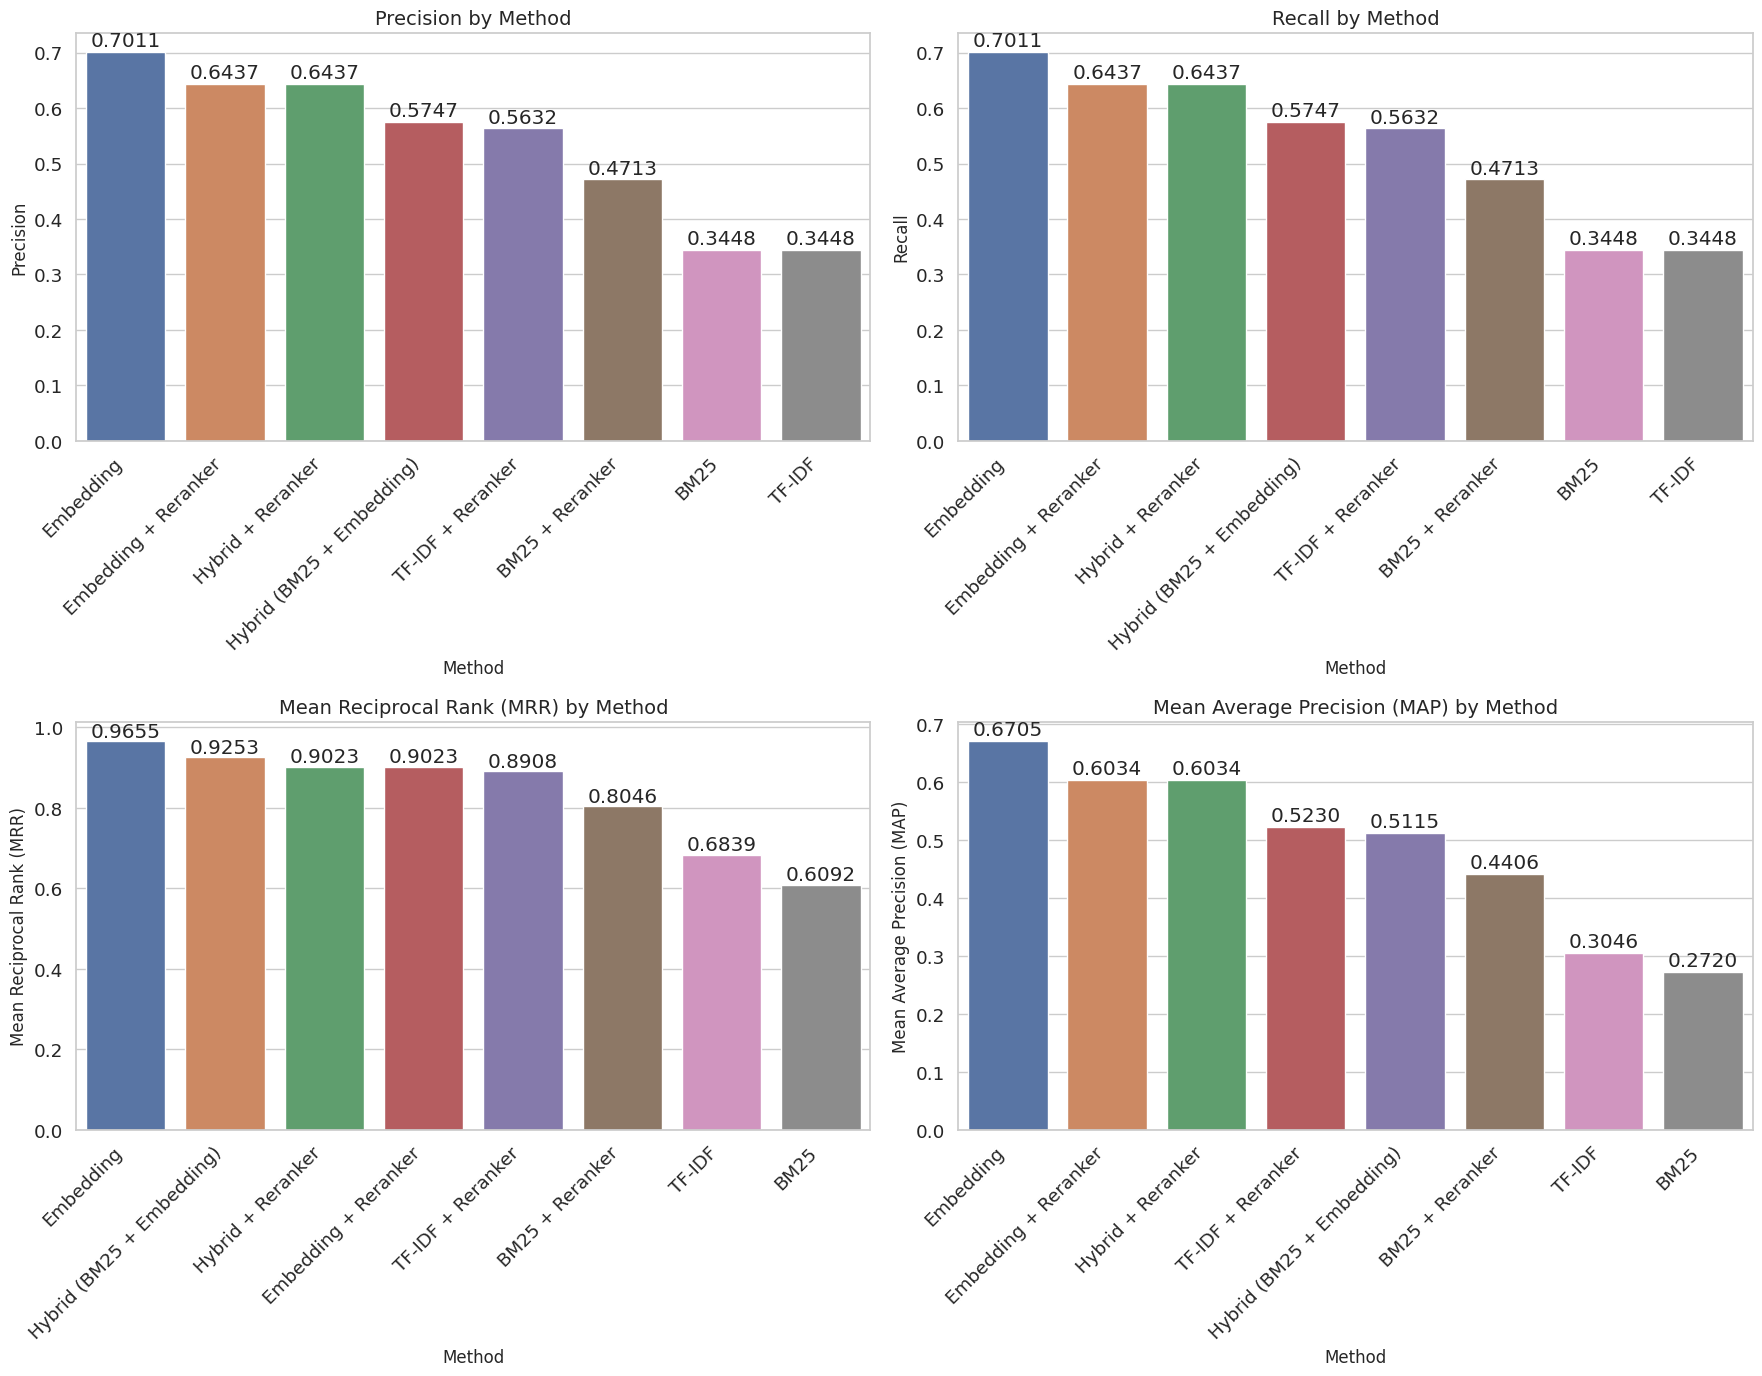

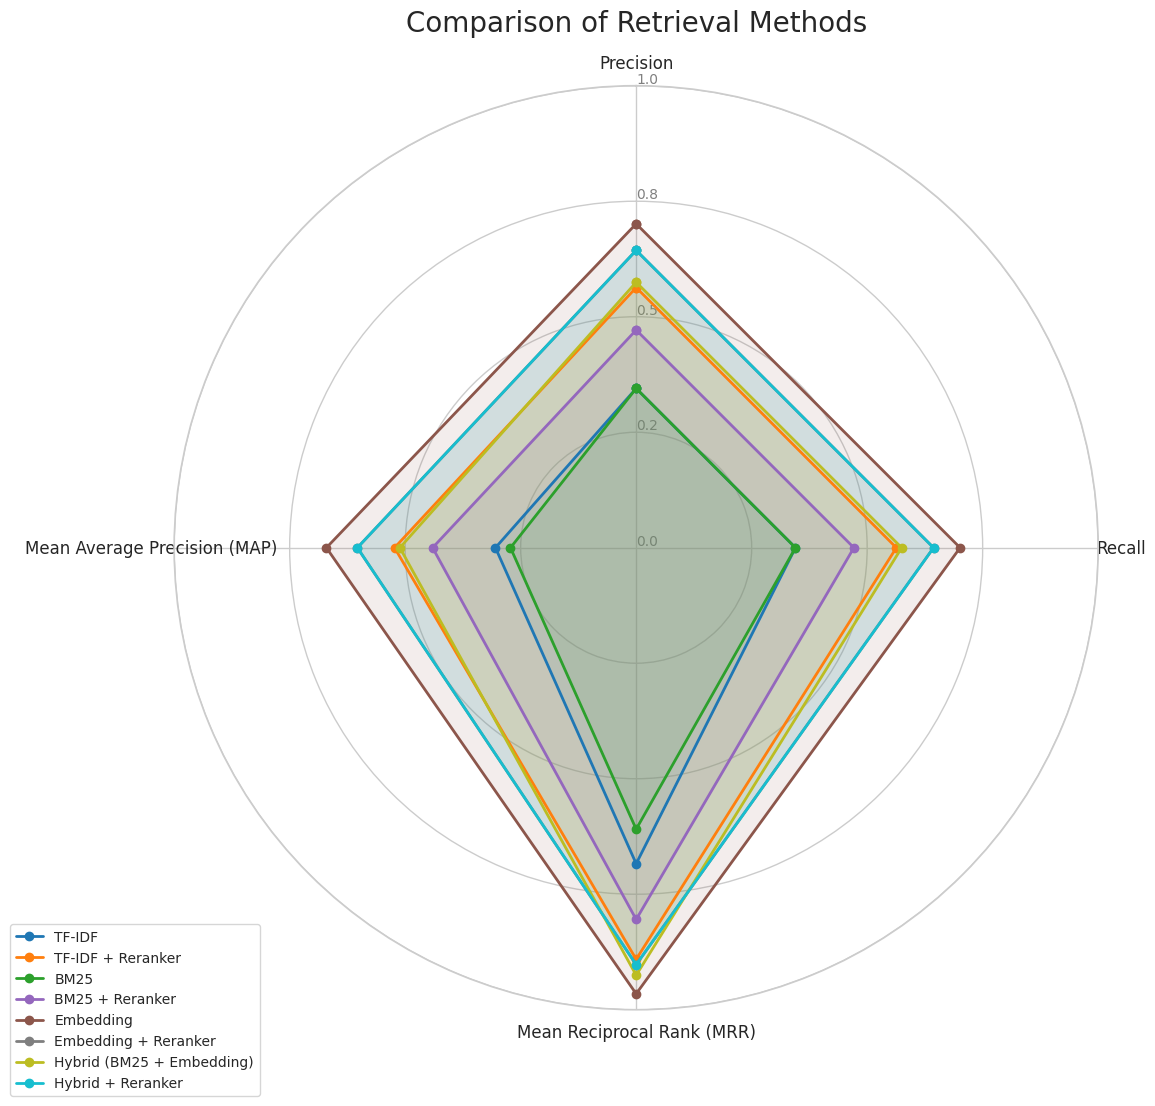

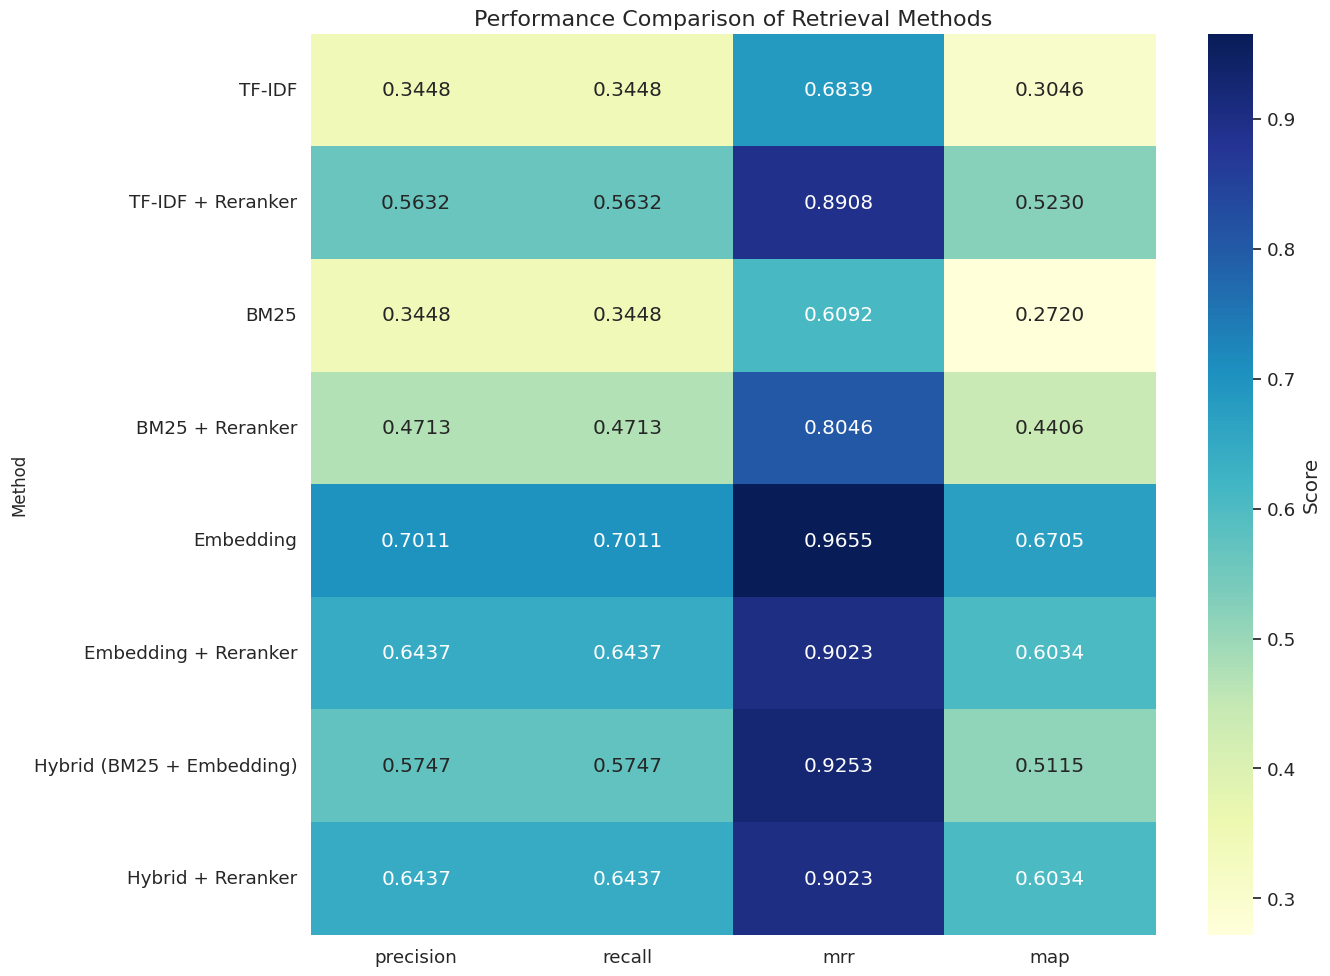

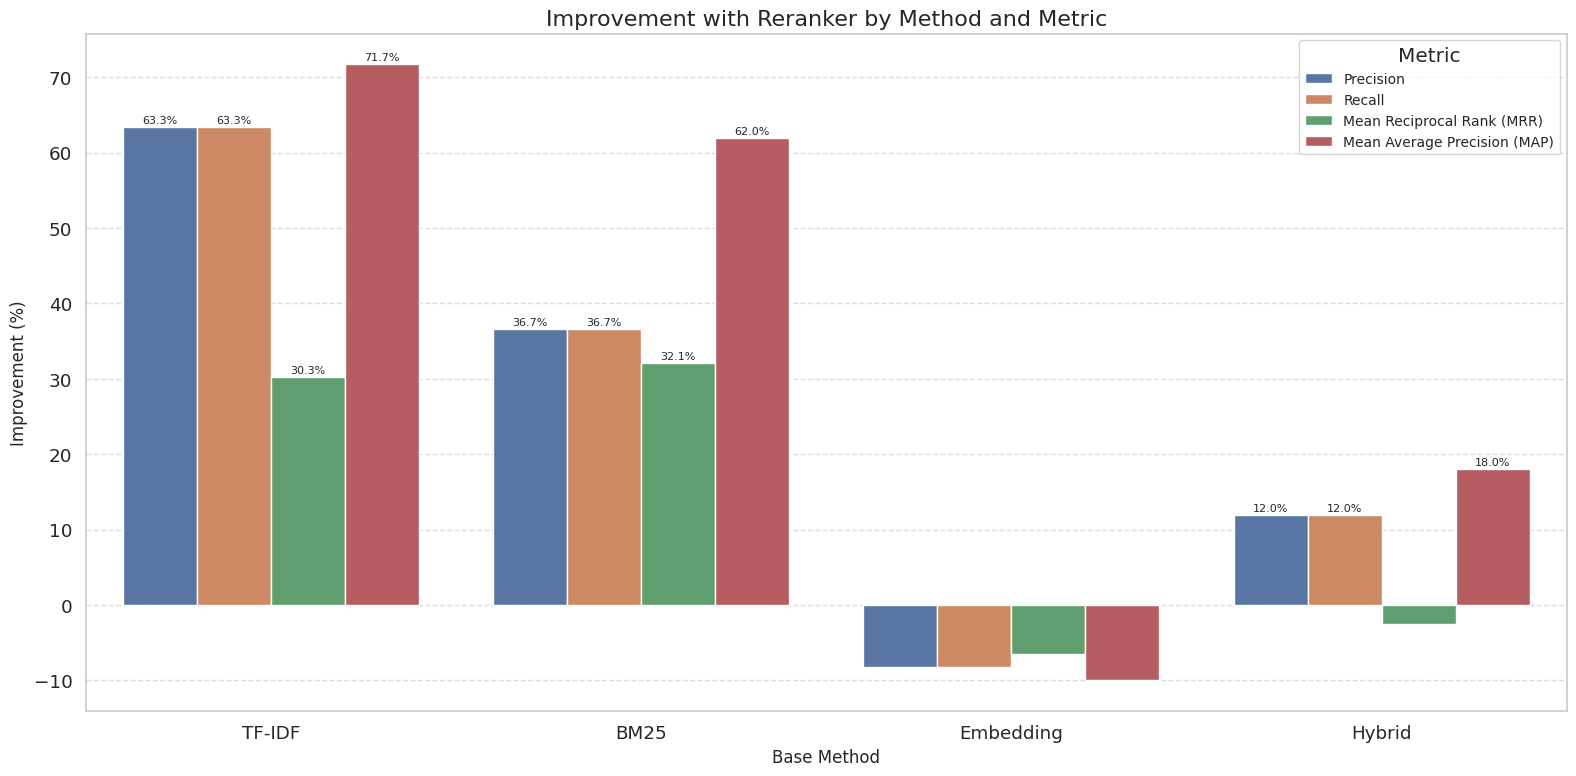

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


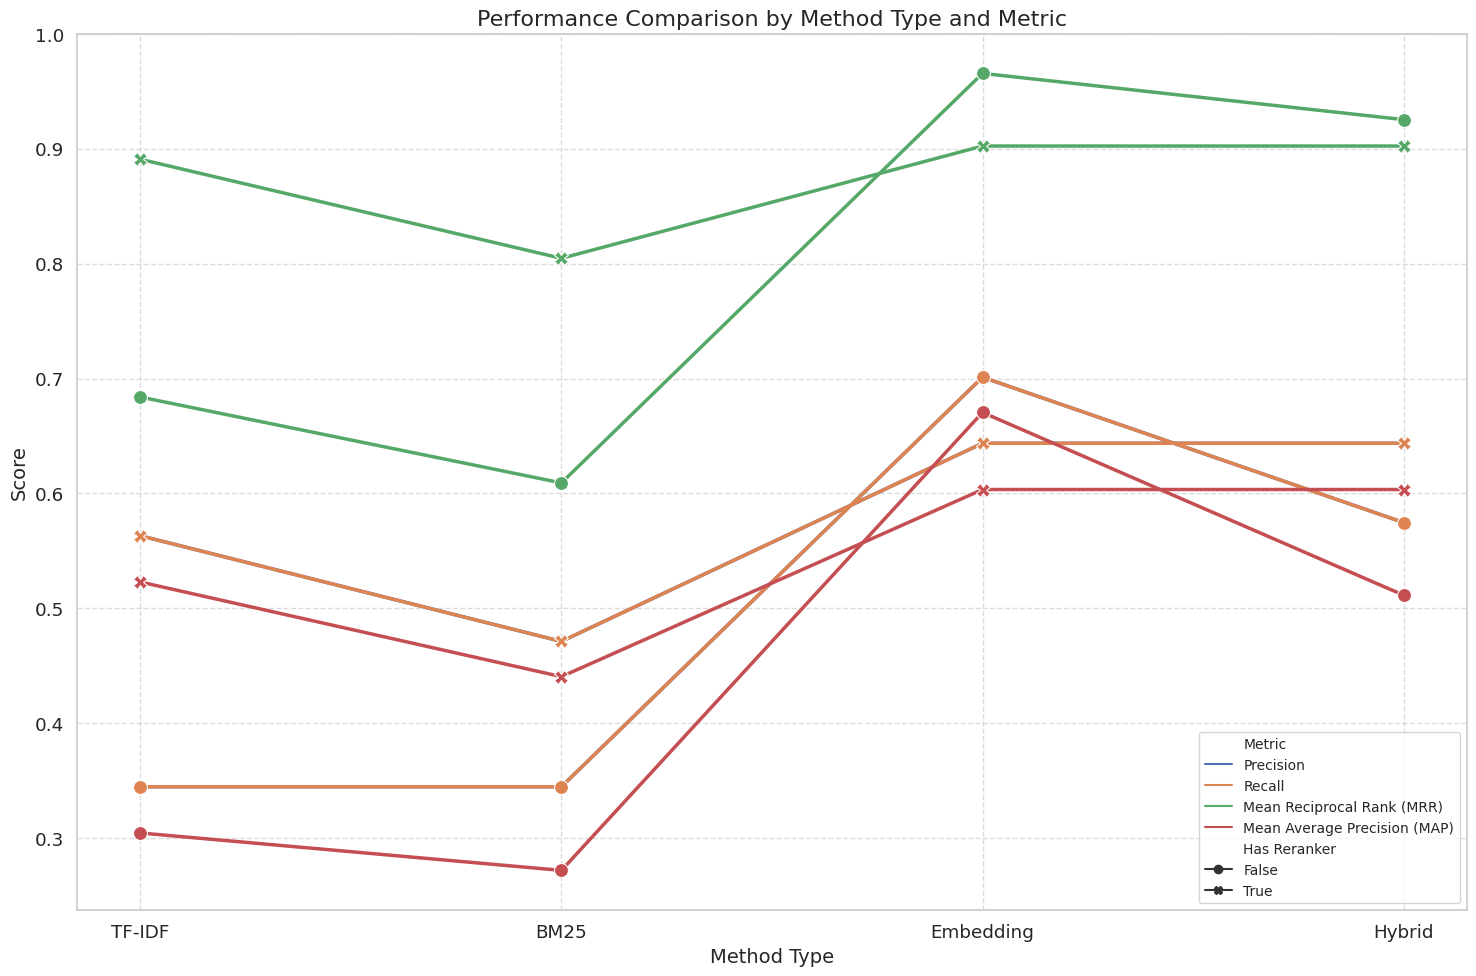


Kết luận từ phân tích:
- Phương pháp tốt nhất cho Precision: Embedding (Giá trị: 0.7011)
- Phương pháp tốt nhất cho Recall: Embedding (Giá trị: 0.7011)
- Phương pháp tốt nhất cho Mean Reciprocal Rank (MRR): Embedding (Giá trị: 0.9655)
- Phương pháp tốt nhất cho Mean Average Precision (MAP): Embedding (Giá trị: 0.6705)

- Phương pháp tốt nhất tổng thể: Embedding (Điểm trung bình: 0.7596)

- Tác động của reranker:
  + TF-IDF: Cải thiện 51.37%
  + BM25: Cải thiện 39.27%
  + Embedding: Cải thiện -8.07%
  + Hybrid: Cải thiện 8.00%


KeyError: 'average'

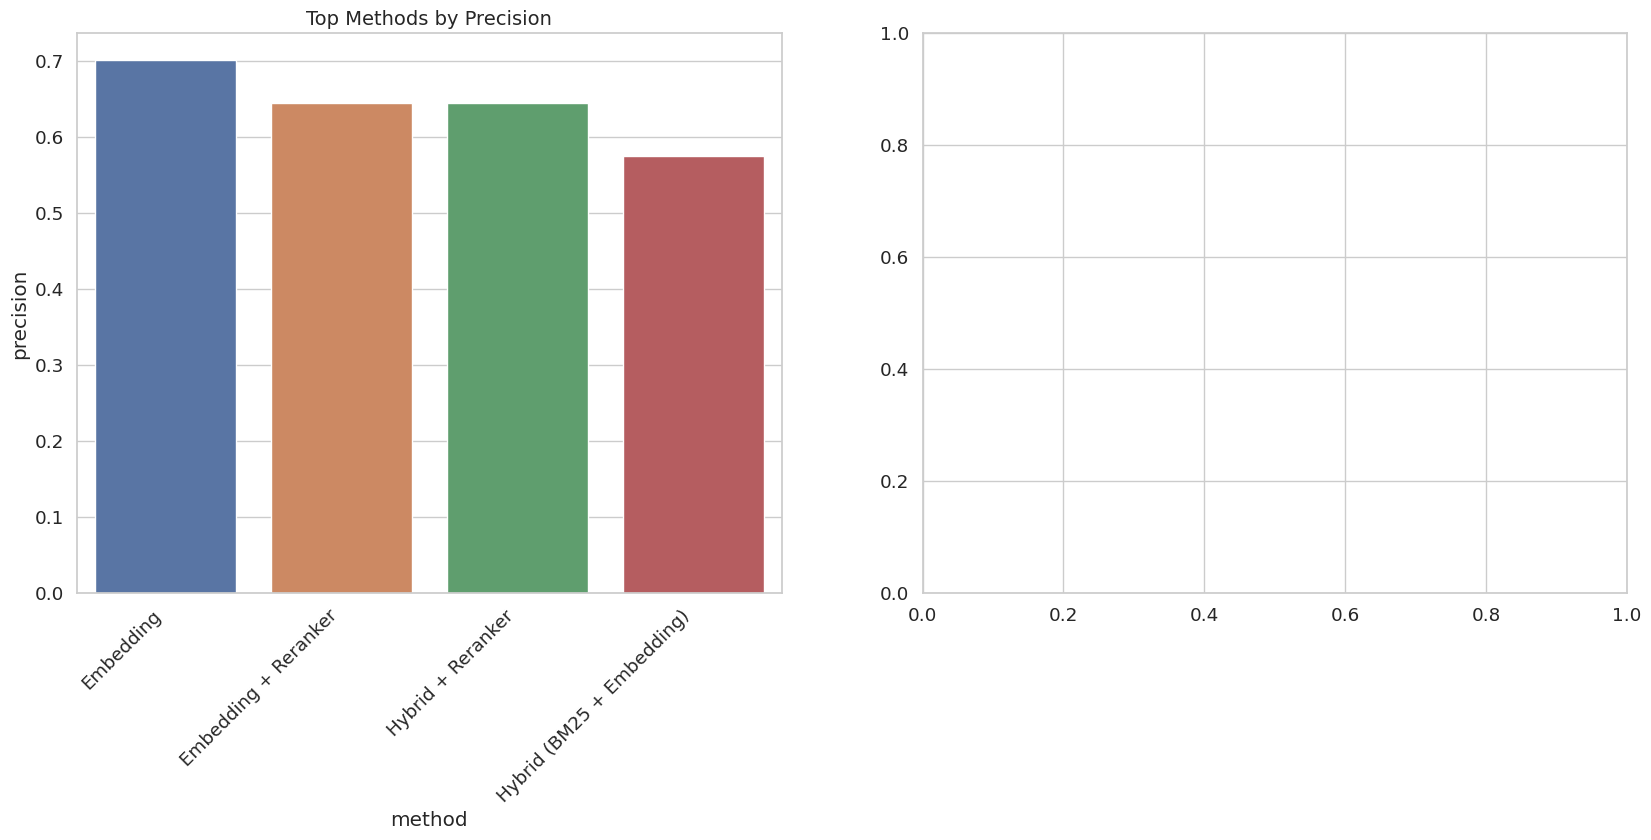

In [211]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Thiết lập style cho biểu đồ
plt.style.use('ggplot')
sns.set(font_scale=1.2)
sns.set_style("whitegrid")

# Vẽ biểu đồ cho từng metric
metrics = ['precision', 'recall', 'mrr', 'map']
metric_names = {
    'precision': 'Precision',
    'recall': 'Recall',
    'mrr': 'Mean Reciprocal Rank (MRR)',
    'map': 'Mean Average Precision (MAP)'
}

fig, axes = plt.subplots(2, 2, figsize=(18, 14))
axes = axes.flatten()

for i, metric in enumerate(metrics):
    # Sắp xếp theo metric giảm dần
    sorted_df = df_results.sort_values(by=metric, ascending=False)
    
    # Vẽ biểu đồ cột
    ax = axes[i]
    sns.barplot(x='method', y=metric, data=sorted_df, ax=ax)
    
    # Thêm nhãn giá trị
    for j, p in enumerate(ax.patches):
        height = p.get_height()
        ax.text(p.get_x() + p.get_width()/2., height + 0.01,
                f'{height:.4f}', ha='center')
    
    # Thiết lập tiêu đề và nhãn
    ax.set_title(f'{metric_names[metric]} by Method', fontsize=14)
    ax.set_xlabel('Method', fontsize=12)
    ax.set_ylabel(metric_names[metric], fontsize=12)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

# Vẽ biểu đồ radar để so sánh các phương pháp
def radar_chart(df, metrics):
    # Chuẩn bị dữ liệu
    methods = df['method'].tolist()
    
    # Số lượng metrics
    N = len(metrics)
    
    # Góc cho mỗi trục
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]  # Đóng vòng tròn
    
    # Khởi tạo biểu đồ
    fig, ax = plt.subplots(figsize=(12, 12), subplot_kw=dict(polar=True))
    
    # Đặt nhãn cho trục
    ax.set_theta_offset(np.pi / 2)  # Xoay để metric đầu tiên ở trên cùng
    ax.set_theta_direction(-1)  # Đi theo chiều kim đồng hồ
    
    # Đặt nhãn cho các trục
    plt.xticks(angles[:-1], [metric_names[m] for m in metrics], size=12)
    
    # Vẽ trục y
    ax.set_rlabel_position(0)
    yticks = np.linspace(0, 1, 5)
    plt.yticks(yticks, [f"{y:.1f}" for y in yticks], color="grey", size=10)
    plt.ylim(0, 1)
    
    # Màu cho mỗi phương pháp
    colors = plt.cm.tab10(np.linspace(0, 1, len(methods)))
    
    # Vẽ dữ liệu cho mỗi phương pháp
    for i, method in enumerate(methods):
        # Lấy giá trị cho phương pháp này
        values = df.loc[df['method'] == method, metrics].values.flatten().tolist()
        values += values[:1]  # Đóng vòng tròn
        
        # Vẽ đường và điểm
        ax.plot(angles, values, 'o-', linewidth=2, color=colors[i], label=method)
        ax.fill(angles, values, color=colors[i], alpha=0.1)
    
    # Thêm legend
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1), fontsize=10)
    
    plt.title('Comparison of Retrieval Methods', size=20, y=1.05)
    return fig

# Vẽ biểu đồ radar
radar_fig = radar_chart(df_results, metrics)
plt.show()

# Vẽ biểu đồ heatmap để so sánh các phương pháp
plt.figure(figsize=(14, 10))
heatmap_data = df_results.set_index('method')[metrics]
sns.heatmap(heatmap_data, annot=True, cmap='YlGnBu', fmt='.4f', cbar_kws={'label': 'Score'})
plt.title('Performance Comparison of Retrieval Methods', fontsize=16)
plt.ylabel('Method', fontsize=12)
plt.tight_layout()
plt.show()

# Vẽ biểu đồ so sánh giữa các phương pháp không có reranker và có reranker
# Chia các phương pháp thành hai nhóm: có reranker và không có reranker
without_reranker = df_results[~df_results['method'].str.contains('Reranker')]
with_reranker = df_results[df_results['method'].str.contains('Reranker')]

# Tạo DataFrame mới để so sánh
comparison_data = []
for method in ['TF-IDF', 'BM25', 'Embedding', 'Hybrid']:
    base_method = without_reranker[without_reranker['method'].str.contains(method)]
    reranker_method = with_reranker[with_reranker['method'].str.contains(method)]
    
    if not base_method.empty and not reranker_method.empty:
        for metric in metrics:
            base_value = base_method[metric].values[0]
            reranker_value = reranker_method[metric].values[0]
            improvement = ((reranker_value - base_value) / base_value) * 100 if base_value > 0 else 0
            
            comparison_data.append({
                'Base Method': method,
                'Metric': metric_names[metric],
                'Improvement (%)': improvement
            })

df_comparison = pd.DataFrame(comparison_data)

# Vẽ biểu đồ cột cho sự cải thiện
plt.figure(figsize=(16, 8))
sns.barplot(x='Base Method', y='Improvement (%)', hue='Metric', data=df_comparison)
plt.title('Improvement with Reranker by Method and Metric', fontsize=16)
plt.xlabel('Base Method', fontsize=12)
plt.ylabel('Improvement (%)', fontsize=12)
plt.legend(title='Metric', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Thêm nhãn giá trị
for i, p in enumerate(plt.gca().patches):
    height = p.get_height()
    if height > 0:
        plt.gca().text(
            p.get_x() + p.get_width()/2., height + 0.5,
            f'{height:.1f}%', ha='center', fontsize=8
        )

plt.tight_layout()
plt.show()

# Tạo biểu đồ line để so sánh xu hướng giữa các phương pháp
plt.figure(figsize=(15, 10))

# Tạo một melted dataframe để vẽ biểu đồ line
melted_df = pd.melt(df_results, 
                    id_vars=['method'], 
                    value_vars=metrics,
                    var_name='Metric', 
                    value_name='Score')
melted_df['Metric'] = melted_df['Metric'].map(metric_names)

# Phân chia phương pháp
method_types = []
for method in melted_df['method']:
    if 'Hybrid' in method:
        method_types.append('Hybrid')
    elif 'TF-IDF' in method:
        method_types.append('TF-IDF')
    elif 'BM25' in method:
        method_types.append('BM25')
    elif 'Embedding' in method:
        method_types.append('Embedding')
    else:
        method_types.append('Other')

melted_df['Method Type'] = method_types
melted_df['Has Reranker'] = melted_df['method'].str.contains('Reranker')

# Vẽ biểu đồ line theo loại phương pháp và metric
sns.lineplot(
    data=melted_df,
    x='Method Type',
    y='Score',
    hue='Metric',
    style='Has Reranker',
    markers=True,
    dashes=False,
    linewidth=2.5,
    markersize=10
)

plt.title('Performance Comparison by Method Type and Metric', fontsize=16)
plt.xlabel('Method Type', fontsize=14)
plt.ylabel('Score', fontsize=14)
plt.legend(title_fontsize=12, fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('line_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Kết luận
print("\nKết luận từ phân tích:")
best_methods = {}
for metric in metrics:
    best_method = df_results.loc[df_results[metric].idxmax(), 'method']
    best_value = df_results.loc[df_results[metric].idxmax(), metric]
    best_methods[metric] = (best_method, best_value)
    print(f"- Phương pháp tốt nhất cho {metric_names[metric]}: {best_method} (Giá trị: {best_value:.4f})")

# Phương pháp tốt nhất tổng thể
overall_best = df_results.copy()
overall_best['average'] = overall_best[metrics].mean(axis=1)
best_overall = overall_best.loc[overall_best['average'].idxmax(), 'method']
best_overall_value = overall_best.loc[overall_best['average'].idxmax(), 'average']
print(f"\n- Phương pháp tốt nhất tổng thể: {best_overall} (Điểm trung bình: {best_overall_value:.4f})")

# Đánh giá tác động của reranker
reranker_impact = {}
for method in ['TF-IDF', 'BM25', 'Embedding', 'Hybrid']:
    base_row = df_results[df_results['method'].str.contains(method) & ~df_results['method'].str.contains('Reranker')]
    reranker_row = df_results[df_results['method'].str.contains(method) & df_results['method'].str.contains('Reranker')]
    
    if not base_row.empty and not reranker_row.empty:
        avg_base = base_row[metrics].mean(axis=1).values[0]
        avg_reranker = reranker_row[metrics].mean(axis=1).values[0]
        improvement = ((avg_reranker - avg_base) / avg_base) * 100 if avg_base > 0 else 0
        reranker_impact[method] = improvement

print("\n- Tác động của reranker:")
for method, impact in reranker_impact.items():
    print(f"  + {method}: Cải thiện {impact:.2f}%")

# Tạo dashboard tổng hợp
from matplotlib.gridspec import GridSpec

plt.figure(figsize=(20, 16))
gs = GridSpec(2, 2, figure=plt.gcf())

# Biểu đồ cột cho từng metric
ax1 = plt.subplot(gs[0, 0])
best_methods_df = df_results.sort_values(by='precision', ascending=False).head(4)
sns.barplot(x='method', y='precision', data=best_methods_df, ax=ax1)
ax1.set_title('Top Methods by Precision', fontsize=14)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')

# Biểu đồ heatmap
ax2 = plt.subplot(gs[0, 1])
top_methods = df_results.sort_values(by='average', ascending=False).head(5)['method'].tolist()
heatmap_data = df_results[df_results['method'].isin(top_methods)].set_index('method')[metrics]
sns.heatmap(heatmap_data, annot=True, cmap='YlGnBu', fmt='.4f', ax=ax2)
ax2.set_title('Performance of Top 5 Methods', fontsize=14)

# Biểu đồ improvement
ax3 = plt.subplot(gs[1, 0])
sns.barplot(
    data=df_comparison[df_comparison['Metric'] == 'Mean Average Precision (MAP)'],
    x='Base Method',
    y='Improvement (%)',
    ax=ax3
)
ax3.set_title('MAP Improvement with Reranker', fontsize=14)
ax3.set_ylabel('Improvement (%)')

# Biểu đồ radar cho phương pháp tốt nhất
ax4 = plt.subplot(gs[1, 1], polar=True)
best_method_df = df_results[df_results['method'] == best_overall]
N = len(metrics)
angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1]
values = best_method_df[metrics].values.flatten().tolist()
values += values[:1]
ax4.plot(angles, values, 'o-', linewidth=2, label=best_overall)
ax4.fill(angles, values, alpha=0.25)
ax4.set_theta_offset(np.pi / 2)
ax4.set_theta_direction(-1)
plt.xticks(angles[:-1], [metric_names[m] for m in metrics], size=10)
ax4.set_title('Best Overall Method Performance', fontsize=14)

plt.tight_layout()
plt.show()